# Train and Host a Keras Model with Pipe Mode and Horovod on Amazon SageMaker

Amazon SageMaker is a fully-managed service that provides developers and data scientists with the ability to build, train, and deploy machine learning (ML) models quickly. Amazon SageMaker removes the heavy lifting from each step of the machine learning process to make it easier to develop high-quality models. The SageMaker Python SDK makes it easy to train and deploy models in Amazon SageMaker with several different machine learning and deep learning frameworks, including TensorFlow and Keras.

In this notebook, we train and host a [Keras Sequential model](https://keras.io/getting-started/sequential-model-guide) on SageMaker. The model used for this notebook is a simple deep convolutional neural network (CNN) that was extracted from [the Keras examples](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py).

For training our model, we also demonstrate distributed training with [Horovod](https://horovod.readthedocs.io) and Pipe Mode. Amazon SageMaker's Pipe Mode streams your dataset directly to your training instances instead of being downloaded first, which translates to training jobs that start sooner, finish quicker, and need less disk space.

## Setup

First, we define a few variables that are be needed later in the example.

In [8]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

## The CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is one of the most popular machine learning datasets. It consists of 60,000 32x32 images belonging to 10 different classes (6,000 images per class). Here are the classes in the dataset, as well as 10 random images from each:

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)

### Prepare the dataset for training

To use the CIFAR-10 dataset, we first download it and convert it to TFRecords. This step takes around 5 minutes.

In [9]:
!python generate_cifar10_tfrecords.py --data-dir ./data


Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating ./data/train/train.tfrecords
Generating ./data/validation/validation.tfrecords
Generating ./data/eval/eval.tfrecords
Done!


Next, we upload the data to Amazon S3:

In [10]:
from sagemaker.s3 import S3Uploader

bucket = sagemaker_session.default_bucket()
dataset_uri = S3Uploader.upload('data', 's3://{}/tf-cifar10-example/data'.format(bucket))

display(dataset_uri)

's3://sagemaker-ap-southeast-2-987959606453/tf-cifar10-example/data'

## Train the model

In this tutorial, we train a deep CNN to learn a classification task with the CIFAR-10 dataset. We compare three different training jobs: a baseline training job, training with Pipe Mode, and distributed training with Horovod.

### Run a baseline training job on SageMaker

The SageMaker Python SDK's `sagemaker.tensorflow.TensorFlow` estimator class makes it easy for us to interact with SageMaker. We create one for each of the different training jobs we run in this example. A couple parameters worth noting:

* `entry_point`: our training script (adapted from [this Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)).
* `train_instance_count`: the number of training instances. Here, we set it to 1 for our baseline training job.

As we run each of our training jobs, we change different parameters to configure our different training jobs.

For more details about the TensorFlow estimator class, see the [API documentation](https://sagemaker.readthedocs.io/en/stable/sagemaker.tensorflow.html).

### Verify the training code

Before running the baseline training job, we first use [the SageMaker Python SDK's Local Mode feature](https://sagemaker.readthedocs.io/en/stable/overview.html#local-mode) to check that our code works with SageMaker's TensorFlow environment. Local Mode downloads the [prebuilt Docker image for TensorFlow](https://docs.aws.amazon.com/deep-learning-containers/latest/devguide/deep-learning-containers-images.html) and runs a Docker container locally for a training job. In other words, it simulates the SageMaker environment for a quicker development cycle, so we use it here just to test out our code.

We create a TensorFlow estimator, and specify the `instance_type` to be `'local'` or `'local_gpu'`, depending on our local instance type. This tells the estimator to run our training job locally (as opposed to on SageMaker). We also have our training code run for only one epoch because our intent here is to verify the code, not train an accurate model.

In [11]:
import subprocess

from sagemaker.tensorflow import TensorFlow

instance_type = 'local'

if subprocess.call('nvidia-smi') == 0:
    # Set instance type to GPU if one is present
    instance_type = 'local_gpu'
    
local_hyperparameters = {'epochs': 1, 'batch-size' : 64}

estimator = TensorFlow(entry_point='cifar10_keras_main.py',
                       source_dir='source_dir',
                       role=role,
                       framework_version='1.15.2',
                       py_version='py3',
                       hyperparameters=local_hyperparameters,
                       train_instance_count=1,
                       train_instance_type=instance_type)

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Once we have our estimator, we call `fit()` to start the training job and pass the inputs that we downloaded earlier. We pass the inputs as a dictionary to define different data channels for training.

In [12]:
import os

data_path = os.path.join(os.getcwd(), 'data')

local_inputs = {
    'train': 'file://{}/train'.format(data_path),
    'validation': 'file://{}/validation'.format(data_path),
    'eval': 'file://{}/eval'.format(data_path),
}
estimator.fit(local_inputs)

Creating 7828rhrjz9-algo-1-9g2mh ... 
Creating 7828rhrjz9-algo-1-9g2mh ... done
Attaching to 7828rhrjz9-algo-1-9g2mh
7828rhrjz9-algo-1-9g2mh | WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.
7828rhrjz9-algo-1-9g2mh | 
7828rhrjz9-algo-1-9g2mh | 2021-05-14 10:19:51,755 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
7828rhrjz9-algo-1-9g2mh | 2021-05-14 10:19:51,771 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
7828rhrjz9-algo-1-9g2mh | 2021-05-14 10:19:52,276 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
7828rhrjz9-algo-1-9g2mh | 2021-05-14 10:19:52,333 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
7828rhrjz9-algo-1-9g2mh | 2021-05-14 10:19:52,408 sagemaker-containers INFO     No GPUs detected (normal if no gpus ins

7828rhrjz9-algo-1-9g2mh | Using TensorFlow backend.
7828rhrjz9-algo-1-9g2mh | WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.
7828rhrjz9-algo-1-9g2mh | 
7828rhrjz9-algo-1-9g2mh | WARNING:tensorflow:From cifar10_keras_main.py:30: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.
7828rhrjz9-algo-1-9g2mh | 
7828rhrjz9-algo-1-9g2mh | WARNING:tensorflow:From cifar10_keras_main.py:30: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.
7828rhrjz9-algo-1-9g2mh | 
7828rhrjz9-algo-1-9g2mh | INFO:root:Writing TensorBoard logs to s3://sagemaker-ap-southeast-2-987959606453/tensorflow-training-2021-05-14-10-19-37-516/model
7828rhrjz9-algo-1-9g2mh | INFO:root:Running with MPI=False
7828rhrjz9-algo-1-9g2mh | INFO:root:getting data
7828rhrjz9-algo-1-9g2mh | INFO:root:Running

7828rhrjz9-algo-1-9g2mh | INFO:tensorflow:SavedModel written to: /opt/ml/model/1/saved_model.pb
7828rhrjz9-algo-1-9g2mh | INFO:tensorflow:SavedModel written to: /opt/ml/model/1/saved_model.pb
7828rhrjz9-algo-1-9g2mh | INFO:root:Model successfully saved at: /opt/ml/model
7828rhrjz9-algo-1-9g2mh | 2021-05-14 10:29:48,019 sagemaker-containers INFO     Reporting training SUCCESS
7828rhrjz9-algo-1-9g2mh exited with code 0
Aborting on container exit...
===== Job Complete =====


### Run a baseline training job on SageMaker

Now we run training jobs on SageMaker, starting with our baseline training job.

### Configure metrics

In addition to running the training job, Amazon SageMaker can retrieve training metrics directly from the logs and send them to CloudWatch metrics. Here, we define metrics we would like to observe:

In [13]:
metric_definitions = [
    {'Name': 'train:loss', 'Regex': '.*loss: ([0-9\\.]+) - accuracy: [0-9\\.]+.*'},
    {'Name': 'train:accuracy', 'Regex': '.*loss: [0-9\\.]+ - accuracy: ([0-9\\.]+).*'},
    {'Name': 'validation:accuracy', 'Regex': '.*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: ([0-9\\.]+).*'},
    {'Name': 'validation:loss', 'Regex': '.*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: ([0-9\\.]+) - val_accuracy: [0-9\\.]+.*'},
    {'Name': 'sec/steps', 'Regex': '.* - \d+s (\d+)[mu]s/step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: [0-9\\.]+'}
]

Once again, we create a TensorFlow estimator, with a couple key modfications from last time:

* `train_instance_type`: the instance type for training. We set this to `ml.p2.xlarge` because we are training on SageMaker now. For a list of available instance types, see [the AWS documentation](https://aws.amazon.com/sagemaker/pricing/instance-types).
* `metric_definitions`: the metrics (defined above) that we want sent to CloudWatch.

In [17]:
from sagemaker.tensorflow import TensorFlow

hyperparameters = {'epochs': 10, 'batch-size': 256}
tags = [{'Key': 'Project', 'Value': 'cifar10'}, {'Key': 'TensorBoard', 'Value': 'file'}]

estimator = TensorFlow(entry_point='cifar10_keras_main.py',
                       source_dir='source_dir',
                       metric_definitions=metric_definitions,
                       hyperparameters=hyperparameters,
                       role=role,
                       framework_version='1.15.2',
                       py_version='py3',
                       train_instance_count=1,
                       train_instance_type='ml.m4.xlarge', # changed from ml.p2.xlarge to ml.m4.xlarge due to 
                                                           # Free Tier allowances
                       base_job_name='cifar10-tf',
                       tags=tags)

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Like before, we call `fit()` to start the SageMaker training job and pass the inputs in a dictionary to define different data channels for training. This time, we use the S3 URI from uploading our data.

In [18]:
inputs = {
    'train': '{}/train'.format(dataset_uri),
    'validation': '{}/validation'.format(dataset_uri),
    'eval': '{}/eval'.format(dataset_uri),
}

estimator.fit(inputs)

2021-05-14 10:37:03 Starting - Starting the training job...
2021-05-14 10:37:27 Starting - Launching requested ML instancesProfilerReport-1620988623: InProgress
......
2021-05-14 10:38:29 Starting - Preparing the instances for training.........
2021-05-14 10:39:55 Downloading - Downloading input data
2021-05-14 10:39:55 Training - Downloading the training image...
2021-05-14 10:40:28 Training - Training image download completed. Training in progress.WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.

2021-05-14 10:40:21,562 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-14 10:40:21,570 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-14 10:40:22,032 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-14 10:40:22,053 sagemaker-conta

 91/156 [================>.............] - ETA: 1:03 - loss: 0.0910 - accuracy: 0.9756


156/156 [==============================] - 165s 1s/step - loss: 0.0531 - accuracy: 0.9858 - val_loss: 0.2961 - val_accuracy: 0.0000e+00


Epoch 2/10
 19/156 [==>...........................] - ETA: 2:01 - loss: 5.2609e-05 - accuracy: 1.0000


110/156 [====================>.........] - ETA: 40s - loss: 4.8070e-05 - accuracy: 1.0000


156/156 [==============================] - 154s 990ms/step - loss: 4.4381e-05 - accuracy: 1.0000 - val_loss: 0.0872 - val_accuracy: 13.4871
Epoch 3/10
 48/156 [========>.....................] - ETA: 1:36 - loss: 2.5772e-05 - accuracy: 1.0000


140/156 [=========================>....] - ETA: 14s - loss: 2.5510e-05 - accuracy: 1.0000


156/156 [==============================] - 155s 995ms/step - loss: 2.4986e-05 - accuracy: 1.0000 - val_loss: 0.0505 - val_accuracy: 19.0850
Epoch 4/10
 77/156 [=============>................] - ETA: 1:10 - loss: 2.1648e-05 - accuracy: 1.0000


156/156 [==============================] - 155s 993ms/step - loss: 1.9022e-05 - accuracy: 1.0000 - val_loss: 0.0542 - val_accuracy: 20.1592
Epoch 5/10
  8/156 [>.............................] - ETA: 2:21 - loss: 9.8969e-06 - accuracy: 1.0000


 99/156 [==================>...........] - ETA: 51s - loss: 1.3679e-05 - accuracy: 1.0000


156/156 [==============================] - 156s 1s/step - loss: 1.2303e-05 - accuracy: 1.0000 - val_loss: 0.0586 - val_accuracy: 21.4052
Epoch 6/10
 35/156 [=====>........................] - ETA: 1:50 - loss: 8.9939e-06 - accuracy: 1.0000


126/156 [=======================>......] - ETA: 26s - loss: 9.1521e-06 - accuracy: 1.0000


156/156 [==============================] - 155s 992ms/step - loss: 8.6404e-06 - accuracy: 1.0000 - val_loss: 0.0508 - val_accuracy: 21.2744
Epoch 7/10
 53/156 [=========>....................] - ETA: 1:31 - loss: 9.9880e-06 - accuracy: 1.0000


137/156 [=========================>....] - ETA: 16s - loss: 8.2556e-06 - accuracy: 1.0000


156/156 [==============================] - 154s 987ms/step - loss: 7.9197e-06 - accuracy: 1.0000 - val_loss: 0.0502 - val_accuracy: 20.9456
Epoch 8/10
 65/156 [===========>..................] - ETA: 1:20 - loss: 7.0179e-06 - accuracy: 1.0000


154/156 [============================>.] - ETA: 1s - loss: 6.1890e-06 - accuracy: 1.0000


156/156 [==============================] - 155s 993ms/step - loss: 6.1500e-06 - accuracy: 1.0000 - val_loss: 0.0516 - val_accuracy: 20.2688
Epoch 9/10
 81/156 [==============>...............] - ETA: 1:07 - loss: 4.5535e-06 - accuracy: 1.0000


156/156 [==============================] - 156s 998ms/step - loss: 4.9719e-06 - accuracy: 1.0000 - val_loss: 0.0557 - val_accuracy: 20.4596
Epoch 10/10
  8/156 [>.............................] - ETA: 2:35 - loss: 5.1534e-06 - accuracy: 1.0000


 98/156 [=================>............] - ETA: 52s - loss: 4.7415e-06 - accuracy: 1.0000


156/156 [==============================] - 156s 1s/step - loss: 4.7050e-06 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 21.1690
INFO:root:Test loss:0.35842132568359375
INFO:root:Test accuracy:0.0


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.






INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /opt/ml/model/1/saved_model.pb
INFO:tensorflow:SavedModel written to: /opt/ml/model/1/saved_model.pb
INFO:root:Model successfully saved at: /opt/ml/model
2021-05-14 11:06:59,931 sagemaker-containers INFO   


2021-05-14 11:07:15 Uploading - Uploading generated training model
2021-05-14 11:07:15 Completed - Training job completed
Training seconds: 1653
Billable seconds: 1653


### View the job training metrics

We can now view the metrics from the training job directly in the SageMaker console.  

Log into the [SageMaker console](https://console.aws.amazon.com/sagemaker/home), choose the latest training job, and scroll down to the monitor section. Alternatively, the code below uses the region and training job name to generate a URL to CloudWatch metrics.

Using CloudWatch metrics, you can change the period and configure the statistics.

In [19]:
from urllib import parse

from IPython.core.display import Markdown

region = sagemaker_session.boto_region_name
cw_url = parse.urlunparse((
    'https',
    '{}.console.aws.amazon.com'.format(region),
    '/cloudwatch/home',
    '',
    'region={}'.format(region),
    'metricsV2:namespace=/aws/sagemaker/TrainingJobs;dimensions=TrainingJobName;search={}'.format(estimator.latest_training_job.name),
))

display(Markdown('CloudWatch metrics: [link]({}). After you choose a metric, '
                 'change the period to 1 Minute (Graphed Metrics -> Period).'.format(cw_url)))

CloudWatch metrics: [link](https://ap-southeast-2.console.aws.amazon.com/cloudwatch/home?region=ap-southeast-2#metricsV2:namespace=/aws/sagemaker/TrainingJobs;dimensions=TrainingJobName;search=cifar10-tf-2021-05-14-10-37-03-005). After you choose a metric, change the period to 1 Minute (Graphed Metrics -> Period).

## Deploy the trained model

After we train our model, we can deploy it to a SageMaker Endpoint, which serves prediction requests in real-time. To do so, we simply call `deploy()` on our estimator, passing in the desired number of instances and instance type for the endpoint.

Because we're using TensorFlow Serving for deployment, our training script saves the model in TensorFlow's SavedModel format. For more details, see [this blog post on deploying Keras and TF models in SageMaker](https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker).

In [20]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------!

### Invoke the endpoint

To verify the that the endpoint is in service, we generate some random data in the correct shape and get a prediction.

In [21]:
import numpy as np

data = np.random.randn(1, 32, 32, 3)
print('Predicted class: {}'.format(np.argmax(predictor.predict(data)['predictions'])))

Predicted class: 1


Now let's use the test dataset for predictions.

In [22]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.



170500096/170498071 [==============================] - 24s 0us/step


With the data loaded, we can use it for predictions:

In [23]:
from keras.preprocessing.image import ImageDataGenerator

def predict(data):
    predictions = predictor.predict(data)['predictions']
    return predictions


predicted = []
actual = []
batches = 0
batch_size = 128

datagen = ImageDataGenerator()
for data in datagen.flow(x_test, y_test, batch_size=batch_size):
    for i, prediction in enumerate(predict(data[0])):
        predicted.append(np.argmax(prediction))
        actual.append(data[1][i][0])

    batches += 1
    if batches >= len(x_test) / batch_size:
        break

With the predictions, we calculate our model accuracy and create a confusion matrix.

In [24]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_pred=predicted, y_true=actual)
display('Average accuracy: {}%'.format(round(accuracy * 100, 2)))

'Average accuracy: 13.7%'

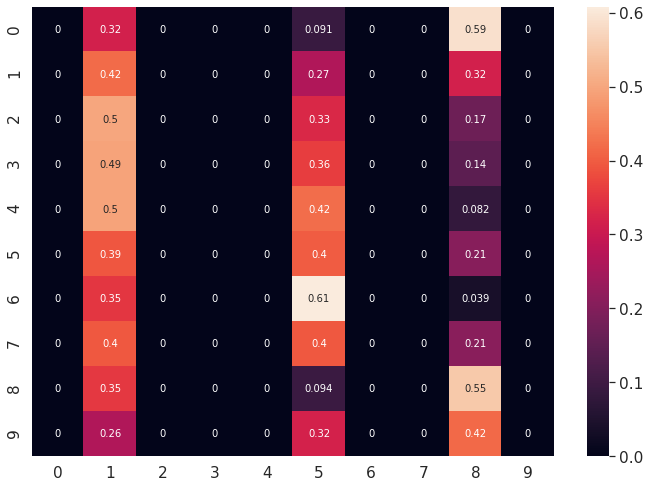

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=predicted, y_true=actual)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sn.set(rc={'figure.figsize': (11.7,8.27)})
sn.set(font_scale=1.4)  # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 10})  # font size

Aided by the colors of the heatmap, we can use this confusion matrix to understand how well the model performed for each label.

## Cleanup

To avoid incurring extra charges to your AWS account, let's delete the endpoint we created:

In [26]:
predictor.delete_endpoint()